In [15]:
#setup colab to upload files for your kaggle.json file
#ensure you have a kaggle json file to download data from kaggle direct
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"matricksdecoder","key":"56eaf77c3c2e685a3fe12d0f6e286f23"}'}

In [16]:
#ensure your kaggle.json file is uploaded
ls -lha kaggle.json

-rw-r--r-- 1 root root 71 Sep 25 10:06 kaggle.json


In [0]:
#setup for downloading from kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [19]:
#download chest x-ray data
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 1.15G/1.15G [00:08<00:00, 104MB/s] 
100% 1.15G/1.15G [00:08<00:00, 138MB/s]


In [22]:

#unzip chest-xray-pneumonia files
from zipfile import ZipFile

zf = ZipFile('chest-xray-pneumonia.zip', 'r')
zf.extractall()
zf.close()
print("Data unzipped")

Data unzipped


In [23]:
#further unzip chest_xray.zip files
zf = ZipFile('chest_xray.zip', 'r')
zf.extractall()
zf.close()
print("Data unzipped")

Data unzipped


In [84]:
#data paths
path_train        = "chest_xray/train"
path_test         = "chest_xray/test"
path_validation   = "chest_xray/val"
print("Data ready")

Data ready


NORMAL


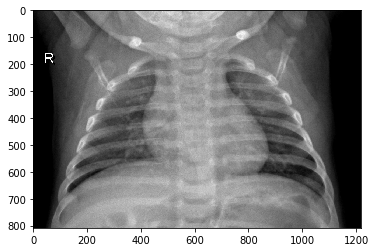

In [95]:
#show example NORMAL image 
from keras.preprocessing.image import ImageDataGenerator, load_img
img_name = 'NORMAL2-IM-0588-0001.jpeg'
img_normal = load_img('chest_xray/train/NORMAL/' + img_name)

print('NORMAL')
plt.imshow(img_normal)
plt.show()

PNEUMONIA


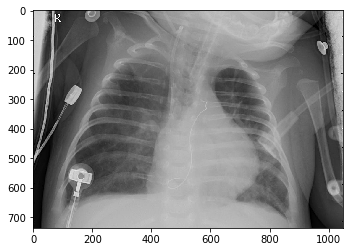

In [96]:

#show example PNEUMONIA image 
img_name = 'person63_bacteria_306.jpeg'
img_pneumonia = load_img('chest_xray/train/PNEUMONIA/' + img_name)

print('PNEUMONIA')
plt.imshow(img_pneumonia)
plt.show()

In [118]:
#setup some parameters
IMAGE_SIZE       = 150
BATCH_SIZE       = 64 #128 best for GPU
EPOCHS           = 10
rescale          = 1./255.0
target_size      = (IMAGE_SIZE, IMAGE_SIZE)
class_mode       = 'categorical'
classes          = ['NORMAL','PNEUMONIA']
print("Parameters set")

Parameters set


In [119]:
#generate data for models 
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=rescale
)
train_generator = train_datagen.flow_from_directory(
    path_train,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    path_validation,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    path_test,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1,
    shuffle=True
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [121]:
# model, transfer learning
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
tf.compat.v1.disable_eager_execution()

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', 
                         include_top=False,
                        input_shape=(IMAGE_SIZE,IMAGE_SIZE,3))

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
# and a logistic layer --with 2 shapes
predictions = Dense(2, activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False
  
model.compile(
    optimizer='rmsprop',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_565 (Conv2D)             (None, 74, 74, 32)   864         input_12[0][0]                   
__________________________________________________________________________________________________
batch_normalization_566 (BatchN (None, 74, 74, 32)   96          conv2d_565[0][0]                 
__________________________________________________________________________________________________
activation_565 (Activation)     (None, 74, 74, 32)   0           batch_norma

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [122]:
# training/fitting model 
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=EPOCHS,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/10
82/82 [==============================] - 383s 5s/step - loss: 0.7945 - acc: 0.7763 - val_loss: 1.2003 - val_acc: 0.5000
Epoch 2/10
82/82 [==============================] - 371s 5s/step - loss: 0.3489 - acc: 0.8535 - val_loss: 1.1159 - val_acc: 0.6875
Epoch 3/10
82/82 [==============================] - 369s 4s/step - loss: 0.2990 - acc: 0.8779 - val_loss: 1.0501 - val_acc: 0.6250
Epoch 4/10
82/82 [==============================] - 370s 5s/step - loss: 0.2867 - acc: 0.8822 - val_loss: 2.2168 - val_acc: 0.5625
Epoch 5/10
82/82 [==============================] - 369s 4s/step - loss: 0.2846 - acc: 0.8820 - val_loss: 1.9727 - val_acc: 0.6250
Epoch 6/10
82/82 [==============================] - 369s 5s/step - loss: 0.2795 - acc: 0.8885 - val_loss: 1.3789 - val_acc: 0.6875
Epoch 7/10
82/82 [==============================] - 371s 5s/step - loss: 0.2566 - acc: 0.8914 - val_loss: 1.5905 - val_acc: 0.6250
Epoch 8/10
82/82 [==============================] - 369s 5s/step - loss: 0.2447 - a

In [124]:
#evaluate model
result = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

624/624 [==============================] - 67s 108ms/step
Loss     : 1.47  
Accuracy : 61.86%


In [0]:
#save model
model.save('pneumonia_prediction_model.h5')